In [21]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import scipy.io as io
import cv2

import base64
import os
from io import BytesIO
from PIL import Image

import h5py

from tools.hsi_to_rgb import hsi_to_rgb
from tools.denoise_spectra import denoise_spectra

In [22]:
"""
This script serves to build the panchromatic (PAN) + hyperspectral (HS) stack with different parameters
by aligning the PAN image to the HS one
"""

'\nThis script serves to build the panchromatic (PAN) + hyperspectral (HS) stack with different parameters\nby aligning the PAN image to the HS one\n'

In [23]:
# Custom Functions

# Normalize the HS across band, NOT every band separately
def np_normalize(array):
    return (array-np.min(array)) /(np.max(array) - np.min(array))

# Find the largest possible rectangle without nan values
def largest_valid_rectangle(mask):
    h, w = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)  # (top, left, height, width)
    dp = [0] * w
    for i in range(h):
        for j in range(w):
            dp[j] = dp[j] + 1 if mask[i][j] else 0

        # Now apply Largest Rectangle in Histogram (LRH) for this row
        stack = []
        for j in range(w + 1):
            height = dp[j] if j < w else 0
            start = j
            while stack and stack[-1][1] > height:
                prev_start, prev_height = stack.pop()
                area = prev_height * (j - prev_start)
                if area > max_area:
                    max_area = area
                    max_rect = (i - prev_height + 1, prev_start, prev_height, j - prev_start)
                start = prev_start
            stack.append((start, height))
    return max_rect


# Select the areas from the hyperspectral and high res RGB photos

In [25]:
# "C:\Users\frcar\Desktop\Git Projects\Aviva analysis\Aviva - spatial fusion - HSI datasets collected with IRIS BRUKER\XGLAB_VISdatacube_AVIVA_complete_1mm.mat" #! entire image, 1156 wavelengths
# "C:\Users\frcar\Desktop\Git Projects\Aviva analysis\Aviva - spatial fusion - HSI datasets collected with IRIS BRUKER\XGLAB_VISdatacube_Avivaface_03mm.mat" #! focus on face, higher res
# matfile = io.loadmat(r"Photos/XGLAB_VISdatacube_AvivaFace_03mm.mat")
matfile = io.loadmat(r"Photos/XGLAB_VISdatacube_AvivaFace_1mm.mat")
print(matfile.keys())
print(np.max(matfile["data"]))

dict_keys(['__header__', '__version__', '__globals__', 'WL', 'data'])
2.109938434476693


(121, 77, 3)


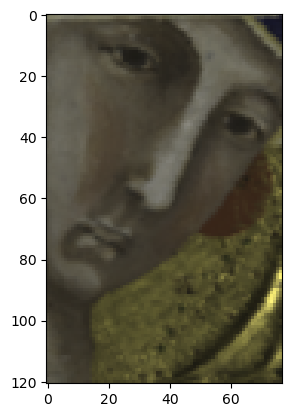

In [26]:
data = matfile["data"]
data = denoise_spectra(data)
wl_cal = matfile["WL"].squeeze()
hsi_rgb = hsi_to_rgb(data,wl_cal)
hsi_rgb = np.rot90(hsi_rgb, k=1)
fig,ax = plt.subplots(1)
ax.imshow(hsi_rgb)
print(hsi_rgb.shape)

(119, 77, 3)


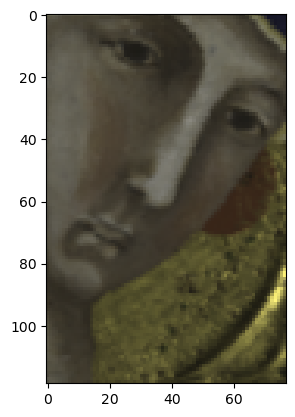

In [30]:
# hsi_target = hsi_rgb[220:300, 200:270]
hsi_target = hsi_rgb[2:122, 0:78]
# target = np.rot90(target, k=1)
fig, axs = plt.subplots()
axs.imshow(hsi_target)
print(hsi_target.shape)

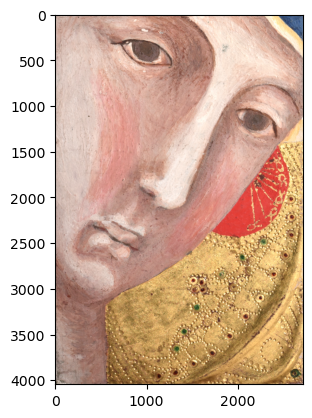

In [31]:
hires_rgb = np.array(Image.open("Photos/Cropped_PAN_ W2710_H4045.jpg"))
fig, axs = plt.subplots()
axs.imshow(hires_rgb)

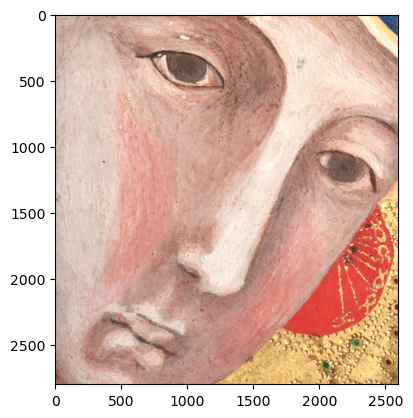

In [32]:
# hr_target = hires_rgb[2100:2900, 1900:3000]
hr_target = hires_rgb[0:2800, 0:2600]
fig, axs = plt.subplots()
axs.imshow(hr_target)

# Now build the stack

(2800, 2600)
(280, 260)


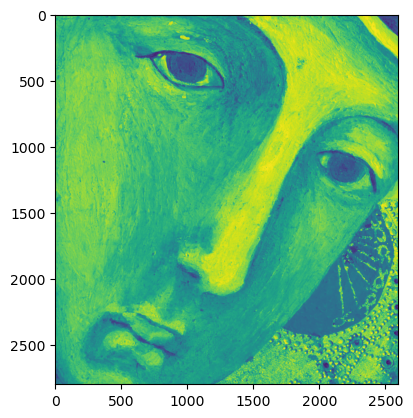

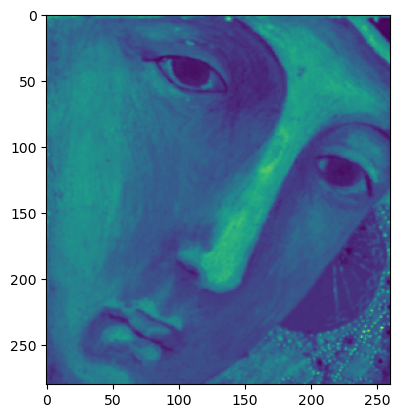

In [91]:
pan = cv2.cvtColor(hr_target, cv2.COLOR_RGB2GRAY)
lr = cv2.cvtColor(hsi_target, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots()
ax.imshow(pan)
print(pan.shape)

fig_lr, ax_lr = plt.subplots()
ax_lr.imshow(lr)
print(lr.shape)

Set the ratio

In [92]:
ratio = 6

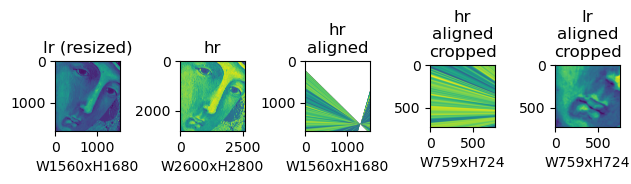

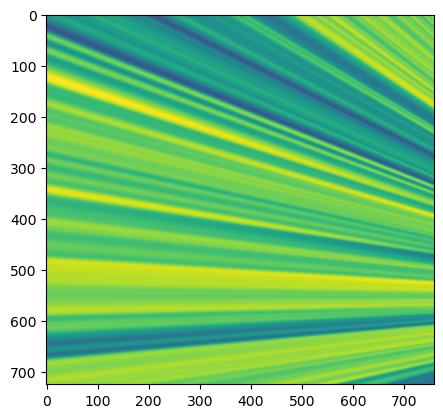

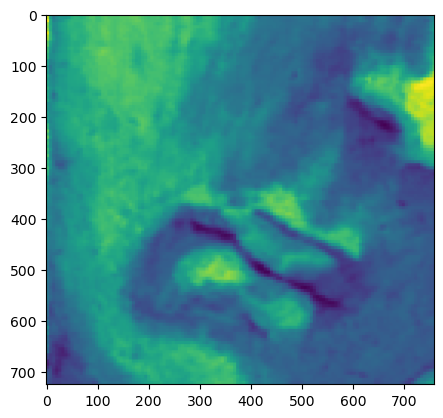

In [93]:
# Align pan to lr
hr = pan

# Normalize and convert to uint8
# lr = np.sum(ms,2) # grayscale lr image, float32
lr = cv2.normalize(lr, None, 0, 255, cv2.NORM_MINMAX)
lr = lr.astype(np.uint8)

hr = cv2.normalize(hr, None, 0, 255, cv2.NORM_MINMAX)
hr = hr.astype(np.uint8)

# Resize low-res to desired res size with NEAREST (could be CUBIC?)
# lr_resized = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC
lr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


###################
# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(500)
kp1, des1 = orb.detectAndCompute(lr_resized, None)
kp2, des2 = orb.detectAndCompute(hr, None)

# Match descriptors using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
lr_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
hr_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# Estimate homography (or affine if preferred)from hr to lr space
H, _ = cv2.findHomography(hr_pts, lr_pts, cv2.RANSAC, 5.0)
# invert the homography: align pan to ms
# H_inv = np.linalg.inv(H)

# Warp low-res image to align with high-res image 
# hr_aligned = cv2.warpPerspective(hr, H, (hr.shape[1], hr.shape[0]))
hr_aligned = cv2.warpPerspective(hr, H, (lr_resized.shape[1], lr_resized.shape[0]))


######################

# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpPerspective(mask, H, (lr_resized.shape[1], lr_resized.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr_resized)
ax[0].set_title("lr (resized)")
ax[0].set_xlabel(f"W{lr_resized.shape[1]}xH{lr_resized.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
ax[4].set_xlabel(f"W{lr_aligned_cropped.shape[1]}xH{lr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(lr_aligned_cropped)

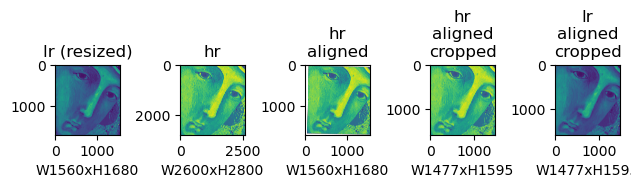

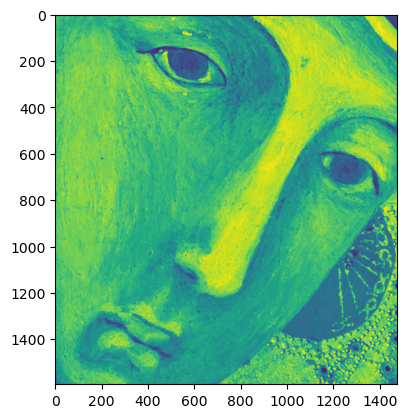

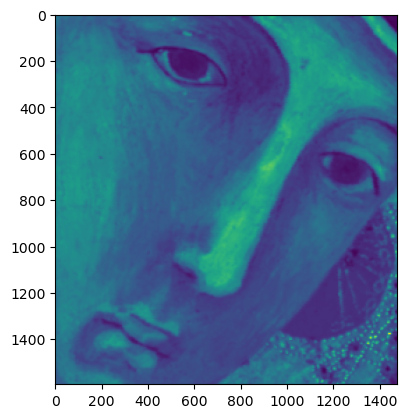

In [94]:
# Use SIFT instead of ORB
# Normalize and convert to uint8
lr = cv2.normalize(lr, None, 0, 255, cv2.NORM_MINMAX)
lr = lr.astype(np.uint8)

hr = cv2.normalize(hr, None, 0, 255, cv2.NORM_MINMAX)
hr = hr.astype(np.uint8)

lr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


sift = cv2.SIFT_create(nfeatures=500)  # OR cv2.xfeatures2d.SIFT_create()

# Detect keypoints + descriptors
kp1, des1 = sift.detectAndCompute(lr_resized, None)
kp2, des2 = sift.detectAndCompute(hr, None)

# Match with KNN matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched points
lr_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
hr_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Estimate affine instead of homography
M, _ = cv2.estimateAffinePartial2D(hr_pts, lr_pts, method=cv2.RANSAC)

# Warp image
hr_aligned = cv2.warpAffine(hr, M, (lr_resized.shape[1], lr_resized.shape[0]))


# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpAffine(mask, M, (lr_resized.shape[1], lr_resized.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr_resized)
ax[0].set_title("lr (resized)")
ax[0].set_xlabel(f"W{lr_resized.shape[1]}xH{lr_resized.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
ax[4].set_xlabel(f"W{lr_aligned_cropped.shape[1]}xH{lr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(lr_aligned_cropped)


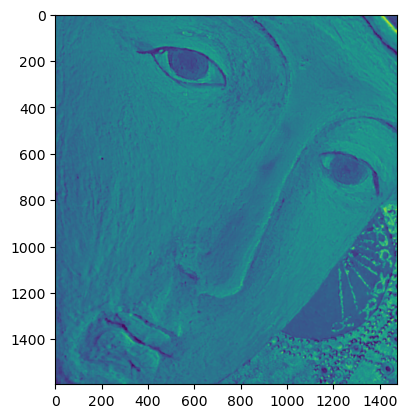

In [95]:
# calculate the error between the resized low res and a blurred high res
err = np.abs(cv2.blur(hr_aligned_cropped, (ratio, ratio)) - lr_aligned_cropped)
figerr, axerr = plt.subplots()
axerr.imshow(err)

When happy with the results, crate the stack

In [100]:
hyperspectral_image = np.rot90(matfile["data"], k = 1)
hs = hyperspectral_image[10:290, 0:260]

#hs = hs[:,:,::100]
# stack will have the height and width of the largest rectangle found with the appropriate function 
stack = np.zeros((height, width, hs.shape[2]+1)) # as many bands as original HS +1 for PAN
for i in range(hs.shape[2]): # for every band/wavelength
    hs_up = cv2.resize(hs[:,:,i], (ratio*hs.shape[1], ratio*hs.shape[0]), interpolation=cv2.INTER_CUBIC)
    stack[:,:,i] = (hs_up[top:top+height, left:left+width])  # select only the rectangle 
stack[:,:,:-1] = np_normalize(stack[:,:,:-1])
stack[:,:,-1] = np_normalize(hr_aligned_cropped.astype("uint16")) # the last layer is the aligned and cropped pan

# ground truth
gt = np_normalize(stack[::ratio,::ratio,:-1]) # <- these are the exact pixels surviving the masking, except the last layer, which is the pan


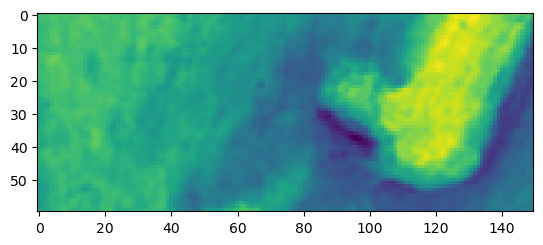

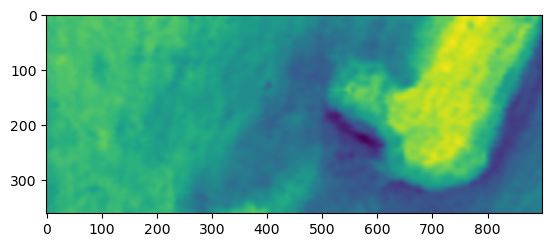

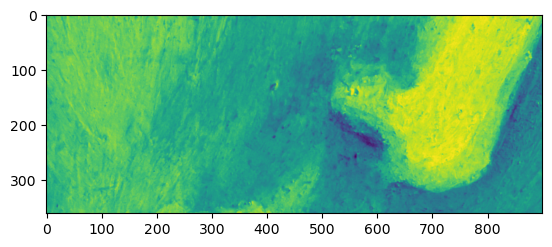

In [121]:
# select only the appropriate area

x0 = 0
xf = 150
y0 = 150
yf = 210

fig0, axs0 = plt.subplots()
axs0.imshow(np.sum(gt[y0:yf, x0:xf, :-1],2))

fig1, axs1 = plt.subplots()
axs1.imshow(np.sum(stack[ratio*y0:ratio*yf, ratio*x0:ratio*xf, :-1],2))

fig2, axs2 = plt.subplots()
axs2.imshow(stack[ratio*y0:ratio*yf, ratio*x0:ratio*xf, -1])


In [ ]:

mat_dict = {
    "I_MS_LR": gt[y0:yf, x0:xf, :],
    #"I_MS": stack[ratio*y0:ratio*yf, ratio*x0:ratio*xf, :-1],
    "I_PAN": stack[ratio*y0:ratio*yf, ratio*x0:ratio*xf, -1],
    "Wavelengths": wl_cal,
}

title = "aviva_nose_aligned_r6_all_wl.mat"
savepath = os.path.join("Datasets", title)
print(savepath)


Datasets/aviva_nose_aligned_r6_all_wl.mat


In [ ]:
# for large datasets
title = "aviva_earring_aligned_r6_all_wl.h5"
savepath = os.path.join("Datasets", title)
print(savepath)
with h5py.File(savepath, "w") as f:
    f.create_dataset("I_MS_LR", data=mat_dict["I_MS_LR"])
    f.create_dataset("I_PAN", data=mat_dict["I_PAN"])
    f.create_dataset("Wavelengths", data=mat_dict["Wavelengths"])

In [124]:
io.savemat(savepath, mat_dict)

# For large datasets
Don't save the upscaled I_MS, save a detail of the HS image

Text(0.5, 1.0, 'I_MS_LR')

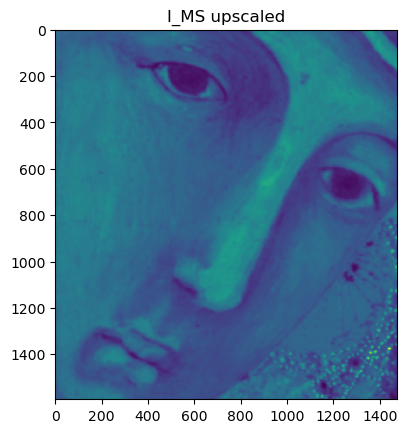

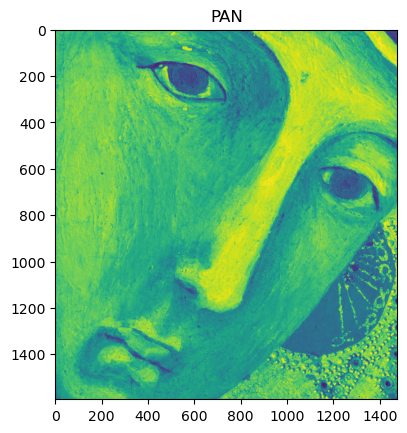

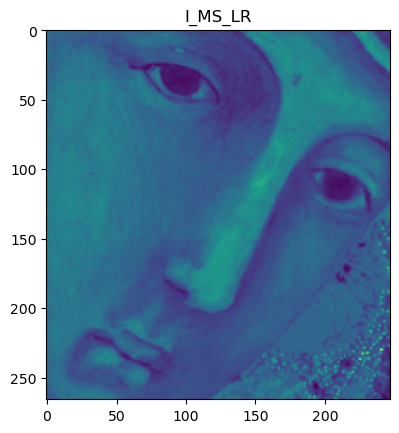

In [ ]:
target_area_top = 0
target_area_height = 10
target_area_left = 0
target_area_width = 10


In [ ]:

figXXX0, axsXXX0 = plt.subplots()
axsXXX0.imshow(np.sum(stack[:, :, :-1],2))
axsXXX0.set_title("I_MS upscaled")
plt.show()


In [ ]:

fig1, axs1 = plt.subplots()
axs1.imshow(stack[:, :, -1])
axs1.set_title("PAN")

fig2, axs2 = plt.subplots()
axs2.imshow(np.sum(gt[:, :, :],2))
axs2.set_title("I_MS_LR")


In [ ]:
fig0_target, axs0_target = plt.subplots()
axs0_target.imshow(np.sum([ratio*(target_area_top):ratio*(target_area_top+target_area_height), ratio*target_area_left:ratio*(target_area_left+target_area_width), :-1],2))
axs0_target.set_title("I_MS upscaled target")

fig1_target, axs1_target = plt.subplots()
axs1_target.imshow(stack[ratio*(target_area_top):ratio*(target_area_top+target_area_height), ratio*target_area_left:ratio*(target_area_left+target_area_width), -1])
axs1_target.set_title("PAN_target")

fig2_target, axs2_target = plt.subplots()
axs2_target.imshow(np.sum(gt[target_area_top:target_area_top+target_area_height, target_area_left:target_area_left+target_area_width, :],2))
axs2_target.set_title("I_MS_LR_target");



Text(0.5, 1.0, 'I_MS_LR_target')

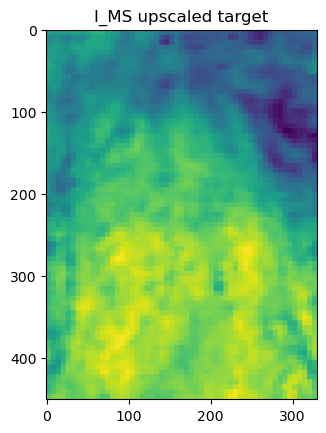

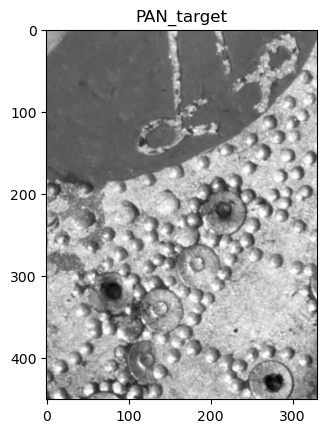

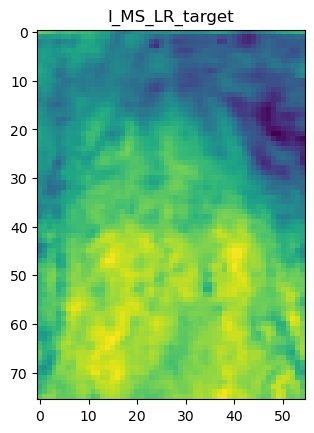

In [22]:
target_area_top = 0
target_area_height = -1
target_area_left = 0
target_area_width = -1

fig0_target, axs0_target = plt.subplots()
axs0_target.imshow(
    np.sum(
        stack[
            ratio * target_area_top : ratio * (target_area_top + target_area_height),
            ratio * target_area_left : ratio * (target_area_left + target_area_width),
            :-1
        ],
        axis=2
    )
)
axs0_target.set_title("I_MS upscaled target")

fig1_target, axs1_target = plt.subplots()
axs1_target.imshow(
    stack[
        ratio * target_area_top : ratio * (target_area_top + target_area_height),
        ratio * target_area_left : ratio * (target_area_left + target_area_width),
        -1
    ],
    cmap='gray'
)
axs1_target.set_title("PAN_target")

fig2_target, axs2_target = plt.subplots()
axs2_target.imshow(
    np.sum(
        gt[
            target_area_top : target_area_top + target_area_height,
            target_area_left : target_area_left + target_area_width,
            :
        ],
        axis=2
    )
)
axs2_target.set_title("I_MS_LR_target")


In [ ]:
hyperspectral_image = np.rot90(data, k = 1)
hs = hyperspectral_image[10:290, 0:260]


alignment_mask = np.zeros(ratio*hs.shape[0], ratio*hs.shape[1])
alignment_mask[top:top+height, left:left+width] = 1

large_mat_dict = {
    "I_MS_LR": hs,
    "I_PAN": np_normalize(hr_aligned_cropped.astype("uint16")),
    "Wavelengths": wl_cal,
    "Mask": mask


}

#hs = hs[:,:,::100]
# stack will have the height and width of the largest rectangle found with the appropriate function 
stack = np.zeros((height, width, hs.shape[2]+1)) # as many bands as original HS +1 for PAN
for i in range(hs.shape[2]): # for every band/wavelength
    hs_up = cv2.resize(hs[:,:,i], (ratio*hs.shape[1], ratio*hs.shape[0]), interpolation=cv2.INTER_NEAREST)
    stack[:,:,i] = (hs_up[top:top+height, left:left+width])  # select only the rectangle 
stack[:,:,:-1] = np_normalize(stack[:,:,:-1])
stack[:,:,-1] = np_normalize(hr_aligned_cropped.astype("uint8")) # the last layer is the aligned and cropped pan

# ground truth
gt = np_normalize(stack[::ratio,::ratio,:-1]) # <- these are the exact pixels surviving the masking, except the last layer, which is the pan


(266, 247, 1156)


if we want to align two hyperspectral images 

we align the first bands of each hyperspectral cube

we can try to align a degraded version of the higher resolution one to the low res band

# Align two Hyperspectral cubes

In [3]:
matfile_sr = io.loadmat(r"Outputs/R-PNN/20250718_182728/aviva_1mm_aligned_r3_R-PNN.mat")
print(matfile_sr.keys())

dict_keys(['__header__', '__version__', '__globals__', 'I_MS', 'Wavelengths'])


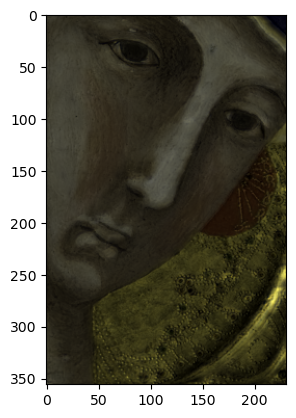

In [4]:
hssr = matfile_sr["I_MS"]
wl_cal = matfile_sr["Wavelengths"].squeeze()
plt.imshow(hsi_to_rgb(hssr, wl_cal))
plt.show()

In [5]:
matfile_hr = io.loadmat(r"Photos/XGLAB_VISdatacube_AvivaFace_03mm.mat")
print(matfile_hr.keys())

dict_keys(['__header__', '__version__', '__globals__', 'WL', 'data'])


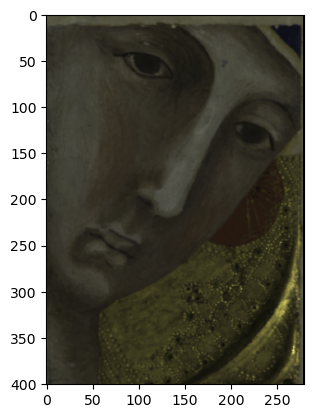

(401, 279, 1018)


In [6]:
wl = matfile_hr["WL"].squeeze()
wl_cal = wl[(wl > 420) & (wl < 1000)]
hshr = matfile_hr["data"][:,:,(wl > 420) & (wl < 1000)] # select the corresponding wavelength

hshr = np.rot90(hshr, k=1) # rotate


hr_rgb = hsi_to_rgb(hshr, wl_cal)
plt.imshow(hr_rgb)
plt.show()

print(hshr.shape)

In [7]:
sr = hssr[:,:,0]
hr = hshr[:,:,0]
ratio = 3

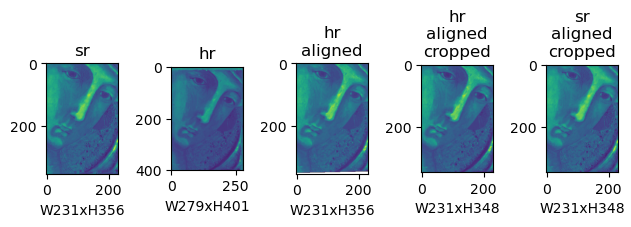

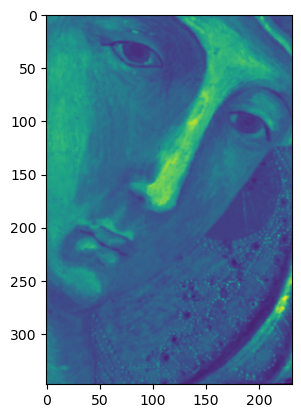

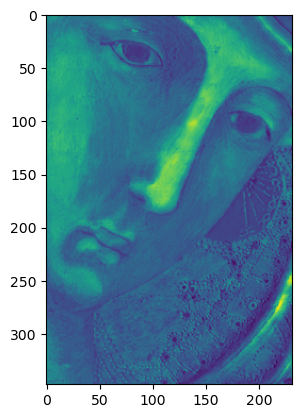

In [10]:
# Use SIFT instead of ORB
# Normalize and convert to uint8
sr = cv2.normalize(sr, None, 0, 255, cv2.NORM_MINMAX)
sr = sr.astype(np.uint8)

hr = cv2.normalize(hr, None, 0, 255, cv2.NORM_MINMAX)
hr = hr.astype(np.uint8)

#sr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


sift = cv2.SIFT_create(nfeatures=500)  # OR cv2.xfeatures2d.SIFT_create()

# Detect keypoints + descriptors
kp1, des1 = sift.detectAndCompute(sr, None)
kp2, des2 = sift.detectAndCompute(hr, None)

# Match with KNN matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched points
sr_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
hr_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Estimate affine instead of homography
M, _ = cv2.estimateAffinePartial2D(hr_pts, sr_pts, method=cv2.RANSAC)

# Warp image
hr_aligned = cv2.warpAffine(hr, M, (sr.shape[1], sr.shape[0]))


# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpAffine(mask, M, (sr.shape[1], sr.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

sr_aligned_cropped =sr[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(sr)
ax[0].set_title("sr")
ax[0].set_xlabel(f"W{sr.shape[1]}xH{sr.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(sr_aligned_cropped)
ax[4].set_title("sr\naligned\ncropped")
ax[4].set_xlabel(f"W{sr_aligned_cropped.shape[1]}xH{sr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(sr_aligned_cropped)

create the hyperspectral stack to be compared between the two

In [78]:
sr_stack = np.zeros((height, width, hssr.shape[2]))
hr_stack = np.zeros((height, width, hssr.shape[2]))
for i in range(hssr.shape[2]):
    sr_stack[:,:,i] = hssr[top:top+height, left:left+width,i]
    hr_aligned_band = cv2.warpAffine(hshr[:,:,i], M, (sr.shape[1], sr.shape[0]))
    hr_stack[:,:,i] = hr_aligned_band[top:top+height, left:left+width]



create the matfile with both to be compared

(the result of the superresolving net is in the Outputs folder. Technically we only need the aligned HR)

In [80]:
mat_dict = {
    "SR":sr_stack,
    "HR":hr_stack,
    "WL":wl_cal
}
savefolder = "Outputs/comparison"
title = "avivaface_sr03mm_vs_hr1mm.mat"
savepath = os.path.join(savefolder, title)
print(savepath)

Outputs/comparison/avivaface_sr03mm_vs_hr1mm.mat


In [81]:
io.savemat(savepath, mat_dict)

In [ ]:
mylist = []
for i in range(10):
    mylist.append(i)

list[slice(0, -3, None)]


# visualize the dataset


In [10]:
matfileLR = io.loadmat(r"Datasets/aviva_1mm_aligned_r3.mat")
print(matfileLR.keys())

dict_keys(['__header__', '__version__', '__globals__', 'I_MS_LR', 'I_PAN', 'Wavelengths'])


In [11]:
LR = matfileLR["I_MS_LR"]
print(LR.shape)
print(np.max(LR))

(119, 77, 1018)
1.0


In [4]:
matfile = io.loadmat(r"Datasets/avivaface_sr03mm_vs_hr1mm.mat")
print(matfile.keys())

dict_keys(['__header__', '__version__', '__globals__', 'SR', 'HR', 'WL'])


In [8]:
HR = matfile["HR"]
print(HR.shape)
print(np.max(HR))

(348, 231, 1018)
1.9240329838780401


# Denoise the spectra
create denoised datasets

In [49]:
from tools.denoise_spectra import denoise_spectra

matfile = io.loadmat(r"Datasets/aviva_nose_aligned_r6_all_wl.mat")
print(matfile.keys())

dict_keys(['__header__', '__version__', '__globals__', 'I_MS_LR', 'I_PAN', 'Wavelengths'])


In [50]:
LR = matfile["I_MS_LR"]
print(LR.shape)


(60, 150, 1156)


In [51]:
LR = denoise_spectra(LR)


In [52]:
matdict = {
    "I_MS_LR": LR,
    "Wavelengths": matfile["Wavelengths"],
    "I_PAN": matfile["I_PAN"]
}

In [53]:
io.savemat("Datasets/denoised_aviva_nose_aligned_r6_all_wl.mat", matdict)